In [23]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
# Define dataset path
DATA_DIR = r"C:\Users\dell\Desktop\Breast_Cancer_ML_model\Augmented_Dataset"  # Replace with actual path

# Get all image paths and labels
cancer_images = [os.path.join(DATA_DIR, "Cancer", img) for img in os.listdir(os.path.join(DATA_DIR, "Cancer"))]
non_cancer_images = [os.path.join(DATA_DIR, "Non-Cancer", img) for img in os.listdir(os.path.join(DATA_DIR, "Non-Cancer"))]

# Create DataFrame
df = pd.DataFrame({
    "filepath": cancer_images + non_cancer_images,
    "label": ["Cancer"] * len(cancer_images) + ["Non-Cancer"] * len(non_cancer_images)
})

# Split into train (80%) & validation (20%)
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Load dataset using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

Found 1796 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.


In [35]:
print(train_generator.class_indices)


{'Cancer': 0, 'Non-Cancer': 1}


1.0


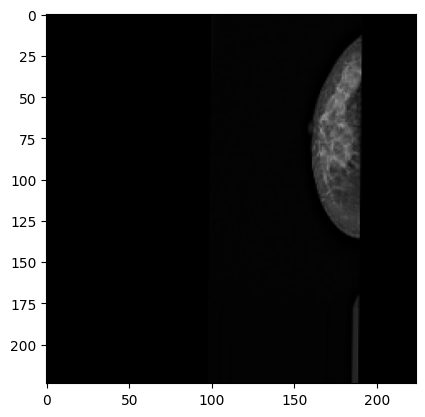

In [36]:
import matplotlib.pyplot as plt
img, label = train_generator.next()
plt.imshow(img[0])
print(label[0])  # Check if the displayed image matches the expected label


In [8]:
# Load Pretrained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Custom Classification Head
x = base_model.output  # Start from base model's output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Connect output_layer to `x`

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # First stage (frozen base model)
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
57/57 [==============================] - 101s 2s/step - loss: 0.3760 - accuracy: 0.8174 - val_loss: 0.2420 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - 48s 837ms/step - loss: 0.2428 - accuracy: 0.9026 - val_loss: 0.2305 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - 27s 464ms/step - loss: 0.2216 - accuracy: 0.9098 - val_loss: 0.2491 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - 29s 501ms/step - loss: 0.2092 - accuracy: 0.9137 - val_loss: 0.1913 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 5/20
57/57 [==============================] - 26s 456ms/step - loss: 0.1919 - accuracy: 0.9215 - val_loss: 0.2016 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 6/20
57/57 [==============================] - 28s 494ms/step - loss: 0.1886 - accuracy: 0.9248 - val_loss: 0.1918 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 7/20
57/57 [==============================] - 28s 487ms/step

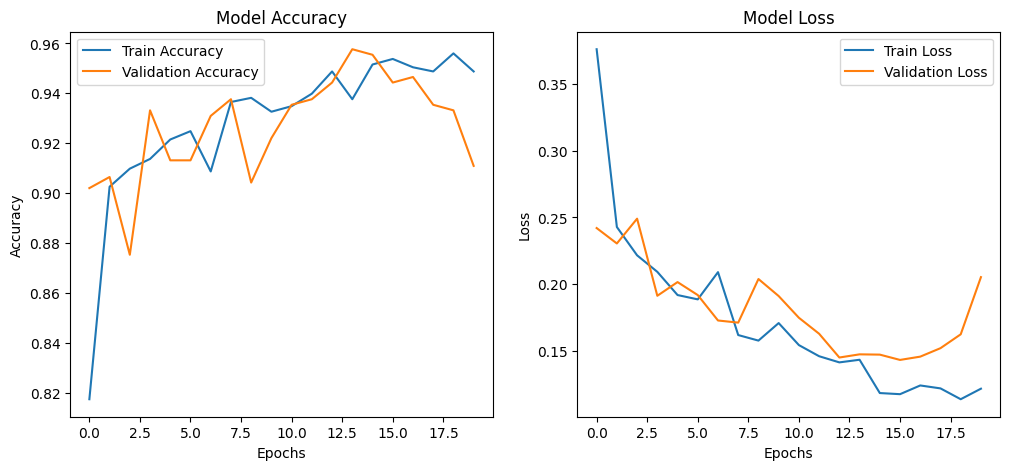

In [10]:
# Plot Training History
def plot_training(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training(history)

15/15 [==============================] - 5s 328ms/step
Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.99      0.89      0.94       325
      Cancer       0.77      0.97      0.86       124

    accuracy                           0.91       449
   macro avg       0.88      0.93      0.90       449
weighted avg       0.93      0.91      0.91       449



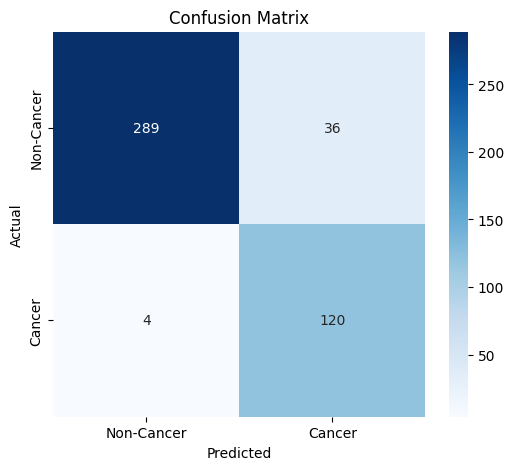

In [11]:
# Generate Predictions
y_true = valid_generator.classes
y_pred_probs = model.predict(valid_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancer", "Cancer"], yticklabels=["Non-Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep first layers frozen
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train again (fine-tuning)
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # Fine-tuning stage
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
57/57 [==============================] - 30s 473ms/step - loss: 0.4624 - accuracy: 0.8686 - val_loss: 0.2468 - val_accuracy: 0.9243 - lr: 1.0000e-05
Epoch 2/20
57/57 [==============================] - 24s 421ms/step - loss: 0.1910 - accuracy: 0.9298 - val_loss: 0.3902 - val_accuracy: 0.8931 - lr: 1.0000e-05
Epoch 3/20
57/57 [==============================] - 23s 405ms/step - loss: 0.1826 - accuracy: 0.9321 - val_loss: 0.3841 - val_accuracy: 0.8953 - lr: 1.0000e-05
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9315
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
57/57 [==============================] - 24s 414ms/step - loss: 0.1708 - accuracy: 0.9315 - val_loss: 0.3787 - val_accuracy: 0.8864 - lr: 1.0000e-05
Epoch 5/20
57/57 [==============================] - 24s 423ms/step - loss: 0.1442 - accuracy: 0.9477 - val_loss: 0.2798 - val_accuracy: 0.9176 - lr: 5.0000e-06
Epoch 6/20
57/57 [=======================

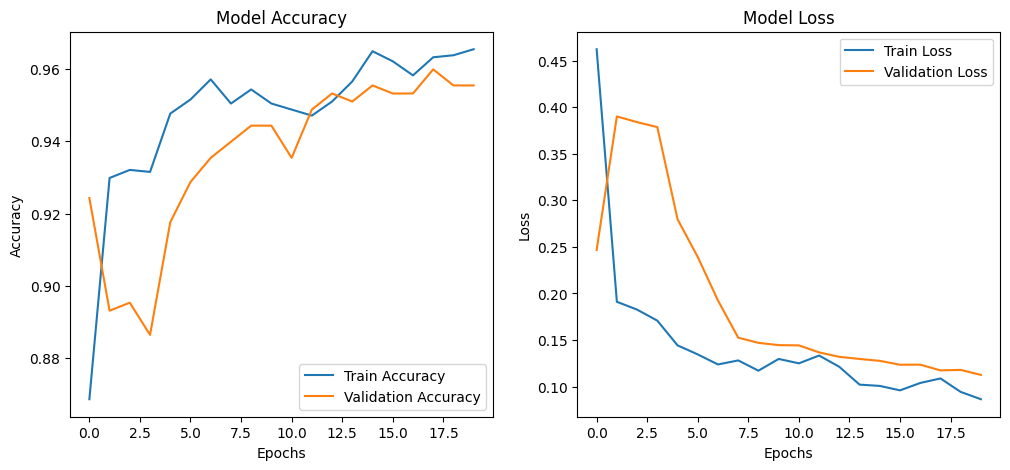

15/15 [==============================] - 4s 214ms/step
Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.98      0.96      0.97       325
      Cancer       0.91      0.94      0.92       124

    accuracy                           0.96       449
   macro avg       0.94      0.95      0.94       449
weighted avg       0.96      0.96      0.96       449



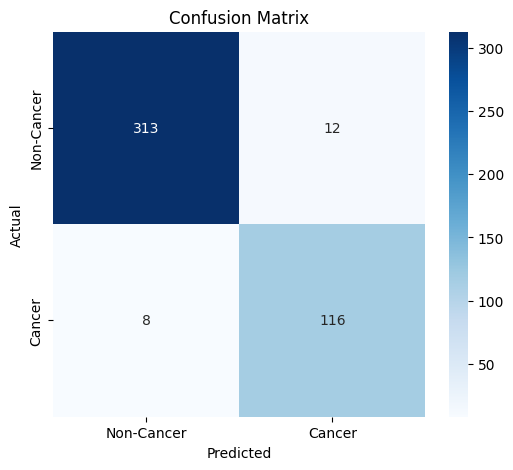

In [14]:
# Save the model
model.save("breast_cancer_xception.h5")

# Plot Training History
def plot_training(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training(history_finetune)

# Generate Predictions
y_true = valid_generator.classes
y_pred_probs = model.predict(valid_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancer", "Cancer"], yticklabels=["Non-Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt  # Import missing library

# Load the trained model
model = tf.keras.models.load_model("breast_cancer_xception.h5")  # Update with the actual path

# Define class labels (matching train_generator.class_indices)
class_labels = ["Cancer", "Non-Cancer"]  

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Preprocesses an image for model prediction.
    - Reads the image in grayscale
    - Converts it to 3-channel (RGB format)
    - Resizes to match model input
    - Normalizes pixel values
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")

    img = cv2.resize(img, img_size)  # Resize
    img = img / 255.0  # Normalize pixel values
    img = np.stack([img] * 3, axis=-1)  # Convert (224, 224, 1) -> (224, 224, 3)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img



def predict_image(image_path):
    """
    Predicts if the given image has cancer or not.
    """
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]  # Get prediction score

    class_idx = 1 if prediction > 0.5 else 0  # Corrected mapping
    confidence = prediction if class_idx == 1 else 1 - prediction
    
    print(f"Prediction: {class_labels[class_idx]} (Confidence: {confidence:.2%})")

    # Show the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


1/1 [==============================] - 0s 25ms/step
Prediction: Non-Cancer (Confidence: 92.77%)


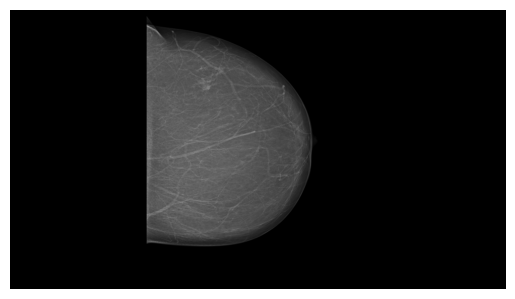

In [6]:
# Example usage
test_image_path = r"C:\Users\dell\Desktop\Breast_Cancer_ML_model\resnet_new\Non-Cancer\IMG (65).jpg"  # Change to your image path
predict_image(test_image_path)
